In [2]:
# 데이터 전처리, 데이터 증강
import matplotlib.pyplot as plt
from torchvision.datasets.cifar import CIFAR10
from torchvision.transforms import ToTensor

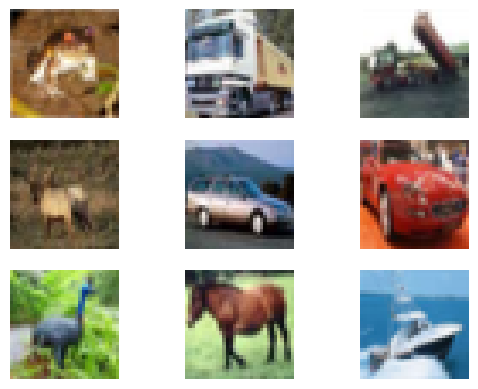

In [3]:
# 데이터셋 불러오기
training_dataset = CIFAR10(root='data/', download=True, transform=ToTensor(), train=True)
test_dataset = CIFAR10(root='data/', download=True, transform=ToTensor(), train=False)

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(training_dataset[i][0].permute(1, 2, 0))
    plt.axis('off')
plt.show()

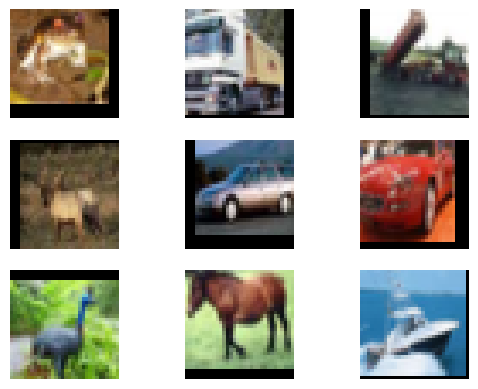

In [4]:
# 크롭핑과 뒤집기 추가
import torchvision.transforms as T
import torchvision.transforms as transforms
from torchvision.transforms import Compose, RandomHorizontalFlip, RandomCrop, ToTensor, Normalize

transform = Compose([
    T.ToTensor(),
    RandomCrop(32, padding=4),
    RandomHorizontalFlip(p=0.5),
])
training_dataset = CIFAR10(root='data/', download=True, transform=transform, train=True)
test_dataset = CIFAR10(root='data/', download=True, transform=transform, train=False)

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(training_dataset[i][0].permute(1, 2, 0))
    plt.axis('off')
plt.show()

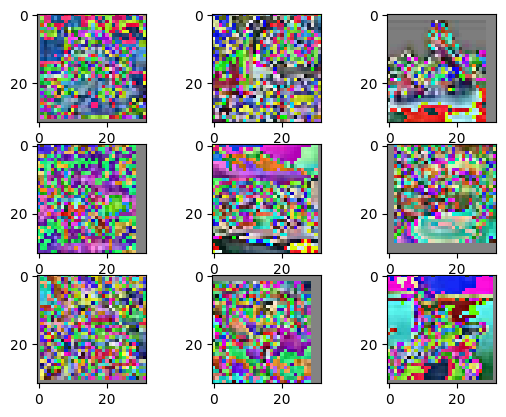

In [5]:
# 데이터 전처리에 정규화를 추가
transform = Compose([
    T.ToPILImage(),
    RandomCrop(32, padding=4),
    RandomHorizontalFlip(p=0.5),
    T.ToTensor(),
    # 데이터 정규화
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.2, 0.2, 0.2]),
    T.ToPILImage()
])
training_dataset = CIFAR10(root='data/', download=True, transform=transform, train=True)
test_dataset = CIFAR10(root='data/', download=True, transform=transform, train=False)

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(transform(training_dataset.data[i]))
plt.show()

In [6]:
import torch.nn as nn
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_dim):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, hidden_dim, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(hidden_dim, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        return x


In [7]:
import torch
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.block1 = BasicBlock(3, 64, 64)
        self.block2 = BasicBlock(64, 128, 128)

        # 분류기
        self.fc1 = nn.Linear(128 * 8 * 8, 2048)
        self.fc2 = nn.Linear(2048, 256)
        self.fc3 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        # x = x.view(x.size(0), -1)  # 평탄화
        x = torch.flatten(x, start_dim=1)  # 배치 차원 유지하면서 평탄화
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [8]:
# 샘플데이터 생성해서 구조 확인
X = torch.randn(4, 3, 32, 32)
model = CNN(num_classes=10)
model(X)

tensor([[ 0.0442, -0.0556,  0.0346, -0.0316,  0.0598,  0.0327, -0.0662,  0.0177,
         -0.0190,  0.0200],
        [ 0.0454, -0.0525,  0.0367, -0.0305,  0.0615,  0.0321, -0.0630,  0.0181,
         -0.0182,  0.0176],
        [ 0.0466, -0.0537,  0.0375, -0.0338,  0.0623,  0.0344, -0.0640,  0.0177,
         -0.0200,  0.0165],
        [ 0.0462, -0.0553,  0.0379, -0.0282,  0.0608,  0.0306, -0.0653,  0.0205,
         -0.0188,  0.0164]], grad_fn=<AddmmBackward0>)

In [9]:
%pip install torchsummary

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# from torchsummary import summary
# model = CNN(num_classes=10).to(device)
# summary(model, input_size=(3, 32, 32))

NameError: name 'device' is not defined

In [11]:
for name, param in model.named_parameters():
    print(f'{name}, {list(param.shape)}')

block1.conv1.weight, [64, 3, 3, 3]
block1.conv1.bias, [64]
block1.conv2.weight, [64, 64, 3, 3]
block1.conv2.bias, [64]
block2.conv1.weight, [128, 64, 3, 3]
block2.conv1.bias, [128]
block2.conv2.weight, [128, 128, 3, 3]
block2.conv2.bias, [128]
fc1.weight, [2048, 8192]
fc1.bias, [2048]
fc2.weight, [256, 2048]
fc2.bias, [256]
fc3.weight, [10, 256]
fc3.bias, [10]


In [ ]:
# 레이어 접근 가능하고 변경도 가능
# model.fc3 = nn.Linear(in_features=256, out_features=2,bias=True)

In [ ]:
from torch.optim import Adam
from tqdm import tqdm
from torch.utils.data import DataLoader
# 데이터 증강
transform = Compose([
    RandomCrop(32, padding=4),
    RandomHorizontalFlip(p=0.5),
    T.ToTensor(),
    # 데이터 정규화
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.2, 0.2, 0.2]),
])
# 데이터 셋
training_dataset = CIFAR10(root='data/', download=True, transform=transform, train=True)
test_dataset = CIFAR10(root='data/', download=True, transform=transform, train=False)

# 데이터 로더
train_loader = DataLoader(training_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN(num_classes=10).to(device)
model.to(device)

lr = 1e-3
optimizer = Adam(model.parameters(), lr=lr)
epochs = 1
# 학습루프
for epoch in range(epochs):
    for data, label in tqdm(train_loader):
        optimizer.zero_grad()
        preds = model(data.to(device))
        loss = nn.CrossEntropyLoss()(preds, label.to(device))
        loss.backward()
        optimizer.step()

    if (epoch+1) % 10 == 0:    
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

torch.save(model.state_dict(), 'cifar.pth')


In [16]:
# 평가
model.load_state_dict(torch.load('cifar.pth', map_location=device))

# 예측
with torch.no_grad():
    model.eval()
    total = 0
    correct = 0
    for data, label in test_loader:
        preds = model(data.to(device))
        _, predicted = torch.max(preds.data, 1)
        total += label.size(0)
        correct += (predicted.cpu() == label).sum().item()
    print(f'Accuracy: {100 * correct / total:.2f}%')
    

FileNotFoundError: [Errno 2] No such file or directory: 'cifar.pth'